## Imports
This includes the time series similarity analysis and enstools

In [2]:
import sys

import numpy as np
import xarray as xr

sys.path.append("enstools.timeseriessimilarity/enstools/")
import timeseriessimilarity.distanceMeasure as dm
import timeseriessimilarity.wrappers as wr
import timeseriessimilarity.tsPlotter as tp
import timeseriessimilarity.clustering as cl
from timeseriessimilarity.plotterFunctions import adjustVisual, barplot_distance, heatmap, annotate_heatmap
from timeseriessimilarity.dataFunctions import prepare_dataset
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Function definitions:

In [3]:
def Sort_Tuple(tup):

    # getting length of list of tuples
    lst = len(tup)
    for i in range(0, lst):

        for j in range(0, lst-i-1):
            if (tup[j][1] > tup[j + 1][1]):
                temp = tup[j]
                tup[j] = tup[j + 1]
                tup[j + 1] = temp
    return tup


def get_dtw_dist(ds, var, ref_mem=0):
    dtw_dist = []
    for e in ds["ens"].values:
        X = ds[var].sel(ens=ref_mem).data
        Y = ds[var].sel(ens=e).data
        optimal_path, dtw_score = dtw_path(X, Y)
        dtw_dist.append((e, dtw_score))
    return dtw_dist


def sort_dtw(dts_distances):
    o_new = []
    sorted_dtw = Sort_Tuple(dts_distances)
    for i in range(len(dts_distances)):
        o_new.append((sorted_dtw[i][0], i))
    return o_new


from matplotlib import pyplot as plt

def evaluate_sil_score(clust):
    eval_sil_score = dict()
    score = np.empty((3, 9))

    for i in range (2, 11):
        clust.generate_cluster(n_cluster=i)
        eval_sil_score[i] = clust.get_silhouette_score()
        score[:, i-2] = eval_sil_score[i].score.values

    plt.plot(score.transpose())
    plt.legend(["Euclidean", "DTW", "Soft-DTW"])
    plt.xticks(np.arange(0, 9, 2), np.arange(2,11,2))
    plt.xlabel("Number of cluster")
    plt.ylabel("Silhouette score")
    plt.tight_layout()


import plotly.express as px
def compute_robustness_matrix(df, sens_names):
    robustness_score = np.empty((len(sens_names), len(sens_names)))
    for i in range(0, len(sens_names)):
        for j in range(0, len(sens_names)):
            robustness_score[i,j] = 1 - (np.where(df[sens_names[i]] != df[sens_names[j]])[0].size / df.shape[0])
    robustness_score = pd.DataFrame(robustness_score, index=sens_names, columns=sens_names)
    pd.DataFrame(robustness_score, index=sens_names, columns=sens_names)
    plt.imshow(pd.DataFrame(robustness_score))
    plt.xticks(range(0, len(sens_names)),labels=sens_names, rotation=90)
    plt.yticks(range(0, len(sens_names)),labels=sens_names)
    plt.colorbar()
    plt.show()
    return robustness_score


from matplotlib import pyplot as plt

def evaluate_sil_score(clust):
    eval_sil_score = dict()
    score = np.empty((3, 9))

    for i in range (2, 11):
        clust.generate_cluster(n_cluster=i)
        eval_sil_score[i] = clust.get_silhouette_score()
        score[:, i-2] = eval_sil_score[i].score.values

    plt.plot(score.transpose())
    plt.legend(["Euclidean", "DTW", "Soft-DTW"])
    plt.xticks(np.arange(0, 9, 2), np.arange(2,11,2))
    plt.xlabel("Number of cluster")
    plt.ylabel("Silhouette score")
    plt.tight_layout()

In [4]:
import pandas as pd

def run_robustness_analysis(base_path, folder_names, file_names, variable_name, ref_member=0, tick_distance=6, ens_range=21, plot_all=False,
                            nr_cluster=3):
    assert (len(folder_list) == len(file_list))
    dsTSs = []
    var_range = (99999999999, -99999999999)

    # create lists of data set and plotter:
    for i in range(0, len(folder_names)):
        ds = xr.open_dataset(base_path + folder_names[i] + file_names[i])
        ds['totalFrontArea_m2'] = ds['totalFrontArea_m2']/1000000
        ds = ds.rename({"trajectory": "ens"}).sel(ensemble=1).drop("ensemble")
        ds = ds.sel({"ens":range(0,ens_range)})

        dsTSs.append(ds)
        var_range = (min(np.nanmin(ds[variable_name].values), var_range[0]), max(np.nanmax(ds[variable_name].values), var_range[1]))

    var_range = (round(var_range[0], 1) - 0.1, round(var_range[1], 1) + 0.1)

    vis_plotter = []
    dist_measure = []
    dist_ordered = []

    for ds in dsTSs:
        vis = tp.tsPlotter(ds, variable_name, tick_distance, var_range, 'plasma', outerHeight=3)
        vis_plotter.append(vis)
        dist = get_dtw_dist(ds, variable_name, ref_member)
        dist_measure.append(dist)

        ordered_dtw = sort_dtw(dist.copy())
        dist_ordered.append(ordered_dtw)
        if plot_all:
            P = vis.visualize_with_order(ordered_dtw, view=0, title="")
            adjustVisual(P, True)

    df_column_names = [fn[9:-9] for fn in file_names]
    df_index_names = [i[0] for i in dist_measure[0]]


    dist_array = np.empty((len(df_index_names), len(df_column_names)))
    i = 0
    for dm in dist_measure:
        dist_array[:,i] = [d[1] for d in dm]
        i += 1

    df_robustness = pd.DataFrame(data=dist_array, index=df_index_names,
                                 columns=df_column_names)

    import plotly.express as px
    fig = px.parallel_coordinates(df_robustness, color=df_robustness.index,
                                  dimensions=df_column_names)
                                  #color_continuous_scale=px.colors.diverging.Tealrose)
    fig.show()

    ## cluster analysis

    ds_cluster = []
    cluster = []

    for ds in dsTSs:
        clust = cl.TimeSeriesClustering(ds, variable)
        clust.generate_cluster(n_cluster=nr_cluster)
        clust.plot_cluster(tickDistance, figure_size=[16,9],dpi=120)
        ds_clust = clust.get_cluster()
        ds_cluster.append(ds_clust)
        cluster.append(ds_clust['cluster'].loc[dict(method='softdtw')].values)

    cluster_array = np.empty((len(df_index_names), len(df_column_names)))
    i = 0
    for clust in cluster:
        cluster_array[:,i] = clust
        i += 1

    df_robustness_cluster = pd.DataFrame(data=cluster_array, index=df_index_names,
                                         columns=df_column_names)

    print(df_robustness_cluster)

    compute_robustness_matrix(df_robustness_cluster, df_column_names)


# 1. Data import and data preparation
Import of the trajectory like structured data file for the time series analysis.
The total front area in $m^2$ is divided by $1.000.000$ to convert it to $km^2$.
Rename the "trajectory" dimension to "ens" and drop "ensemble" dimension. This way the required data format is met.


In [5]:
from geopy.distance import distance 
def filter_distance(l_dicts, lon, lat, distance_km):
    d_filtered_distance = []
    for d in l_dicts:
        dist_km = distance((d['centroid_y'], d['centroid_x']), (lat, lon)).km
        if dist_km <= distance_km:
            d_filtered_distance.append(d)
    return d_filtered_distance

In [6]:
def sort_fronts_area(l_dicts):
    newlist = sorted(l_dicts, key=lambda d: d['totalFrontArea_m2'], reverse=True)
    return newlist

In [7]:
from scipy.stats import wasserstein_distance
def computed_emd(reference, l_dicts, var_key):
    l_emd = []
    for d in l_dicts:
        l_emd.append(wasserstein_distance(reference, d[var_key]))
    return l_emd

In [8]:
import seaborn as sns

def plot_hist_with_emd(l_dicts, l_emd, var_key, scale='count'):
    assert len(l_dicts) == len(l_emd)
    l_stats = [d[var_key] for d in l_dicts]
    
    sns.set(rc={'figure.figsize':(len(l_stats),9)})
    sns.set(font_scale = 2)
    sns.set_style("whitegrid")
    
    ax = sns.violinplot(l_stats, inner="quartile", cut=0, scale=scale)
    ax.set(xlabel='EMD', ylabel=var_key)
    ax.set(xticklabels=l_emd)
    ax.xaxis.grid(True) # Show the vertical gridlines

In [9]:
import pickle
import math
def open_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_dict = pickle.load(f)

    return loaded_dict

def open_pickle_dicts(file_names, folder_path, datacheck=False):
    file_names.sort()
    pickle_dicts = []
    for f in file_names:
        l_timestep = []
        dicts_of_dicts = open_pickle(folder_path + f)
        for key in dicts_of_dicts:
            if datacheck:
                if not (math.isnan(dicts_of_dicts[key]['centroid_x']) | (math.isnan(dicts_of_dicts[key]['centroid_y']))):
                    l_timestep.append(dicts_of_dicts[key])
            else:
                l_timestep.append(dicts_of_dicts[key])
        pickle_dicts.append(l_timestep)
    return pickle_dicts

In [10]:
def filter_front_stats(tracks, d_stats):
    d_filtered_front_stats = []
    i = 0
    for l_ts in d_stats:
        centroid_x = tracks.isel(time=i)['centroid_x'].values[0]
        centroid_y = tracks.isel(time=i)['centroid_y'].values[0]
        for d_fr in l_ts:
            if (abs(d_fr['centroid_x'] - centroid_x) < 0.001) & (abs(d_fr['centroid_y'] - centroid_y) < 0.001): 
                d_filtered_front_stats.append(d_fr)
        i += 1
    return d_filtered_front_stats

In [11]:
def filter_parameter(d_stats, parameter_name):
    l_filtered_parameter = []
    for i in range(0, len(d_stats)):
        l_filtered_parameter.append(d_stats[i][parameter_name])
    return l_filtered_parameter

In [12]:
import seaborn as sns

def plot_histogram_stats_development(l_stats, y_label, xtick_labels, x_label='Time', label_intervall=12, scale="width", rotation=0):
    sns.set(rc={'figure.figsize':(40,9)})
    sns.set(font_scale = 2)
    sns.set_style("whitegrid")
    
    ax = sns.violinplot(l_stats, inner="quartile", cut=0, scale=scale, color='skyblue')
    ax.set(xlabel=x_label, ylabel=y_label)
    ax.set(xticks=np.arange(0, len(l_stats), label_intervall), xticklabels=xtick_labels)
    ax.xaxis.grid(True) # Show the vertical gridlines
    ax.tick_params(axis='x', rotation=rotation)

In [13]:
import os
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
base_path = "exampleData/friederike/tracking_ml/"
files = os.listdir(base_path)


In [14]:
base = datetime.strptime("2018-01-16 12:00", "%Y-%m-%d %H:%M")
date_list = [base + timedelta(hours=int(x)) for x in np.arange(0,73,12)]
date_list = [datetime.strftime(d, "%b %d, %H:%M") for d in date_list]

In [15]:
sns.set(rc={'figure.figsize':(16,9)})
sns.set(rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'})
sns.set(font_scale = 5)

In [16]:
files_ml = [f for f in files if "ml-" in f ]
tracks_ml = xr.open_dataset(base_path + "ECMWF_ens_ml.nc")
dicts_ml = open_pickle_dicts(files_ml, base_path)

dicts_ml_filtered = filter_front_stats(tracks_ml, dicts_ml)

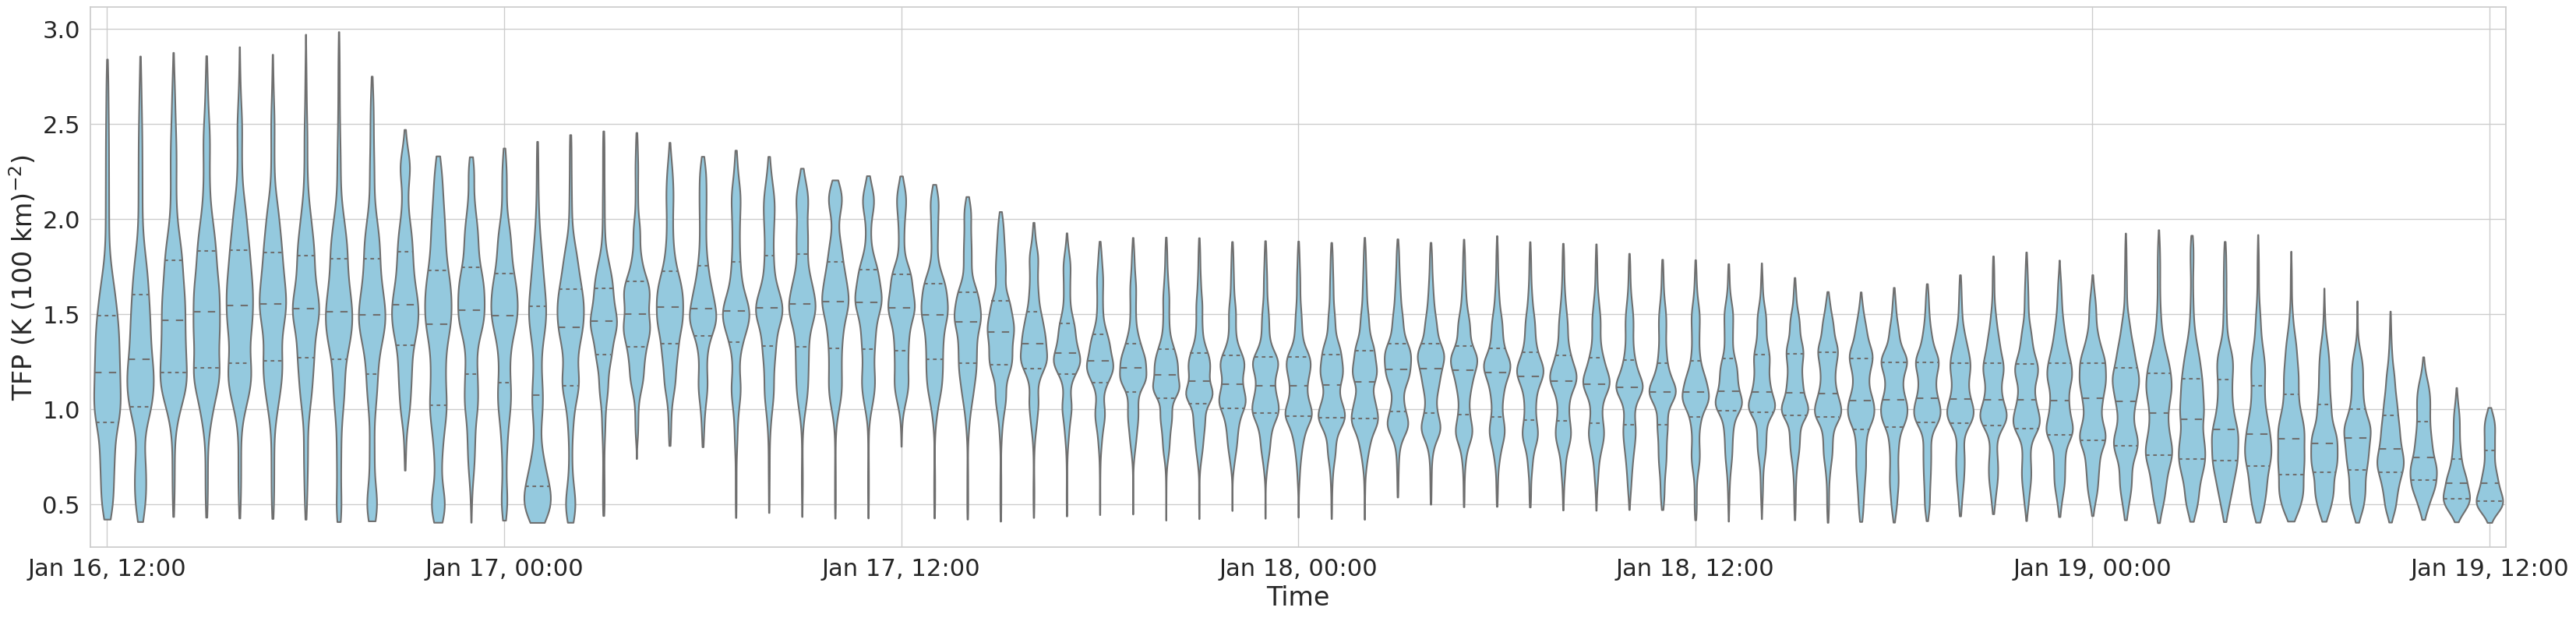

In [17]:
l_tfp_ml = filter_parameter(dicts_ml_filtered, 'tfp_stats')
plot_histogram_stats_development(l_tfp_ml, 'TFP (K (100 km)$^{-2}$)', date_list)                                                 

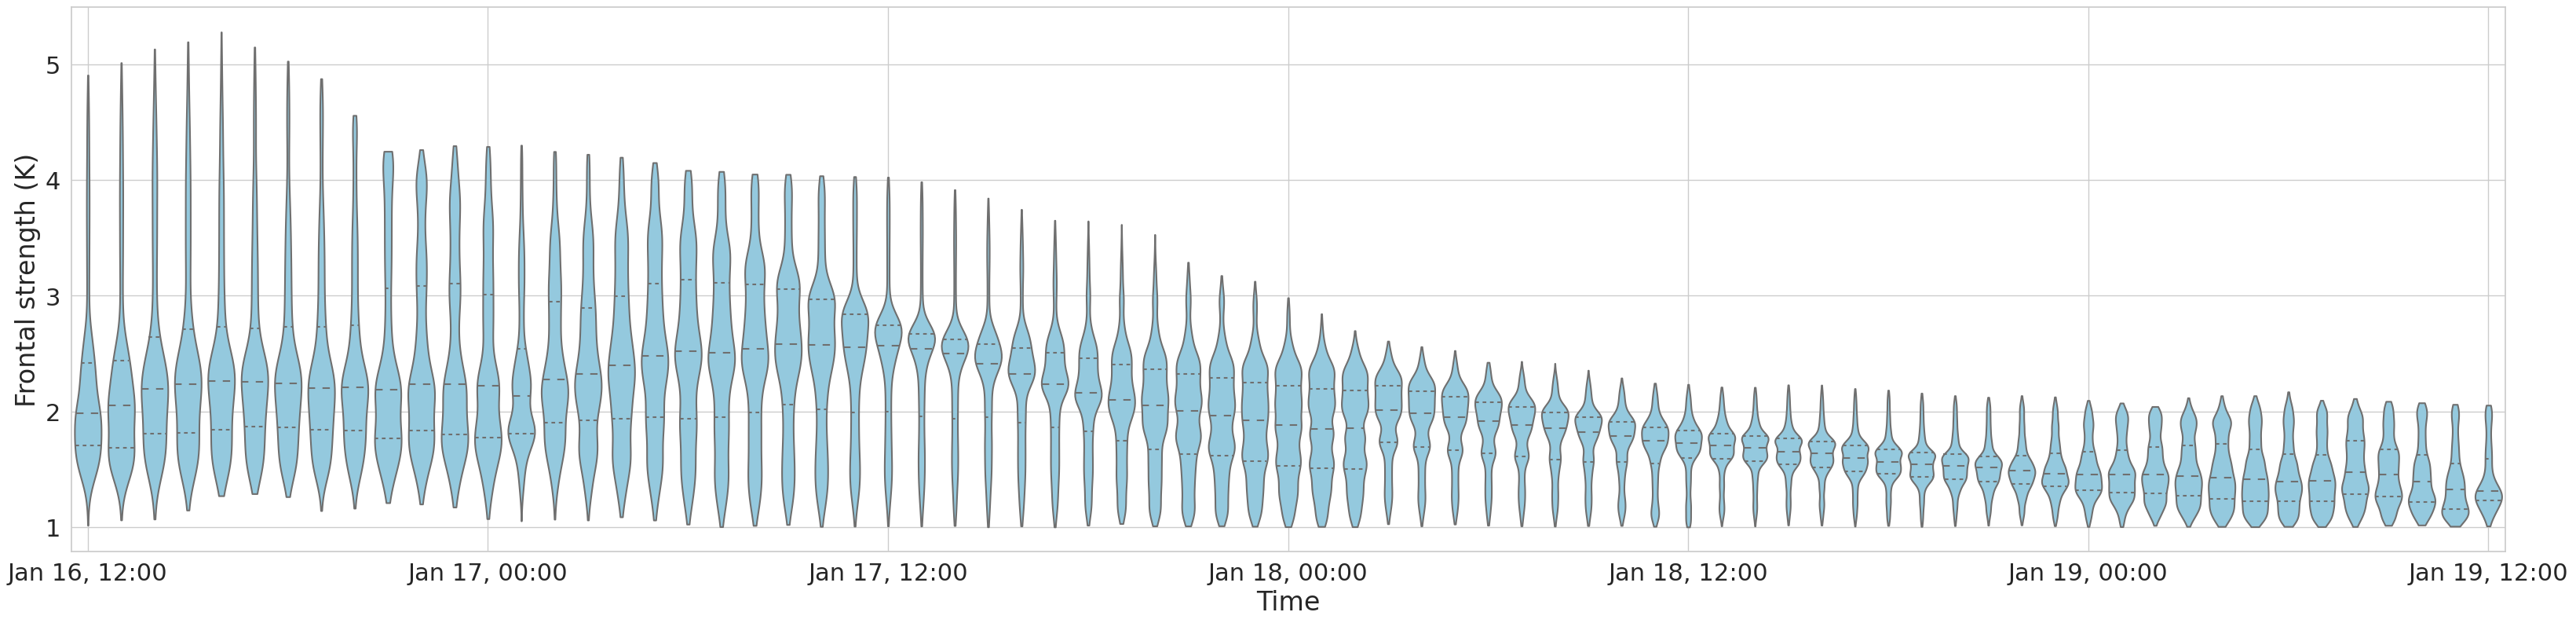

In [18]:
l_strength_ml = filter_parameter(dicts_ml_filtered, 'strength_stats')
plot_histogram_stats_development(l_strength_ml, 'Frontal strength (K)', date_list)     

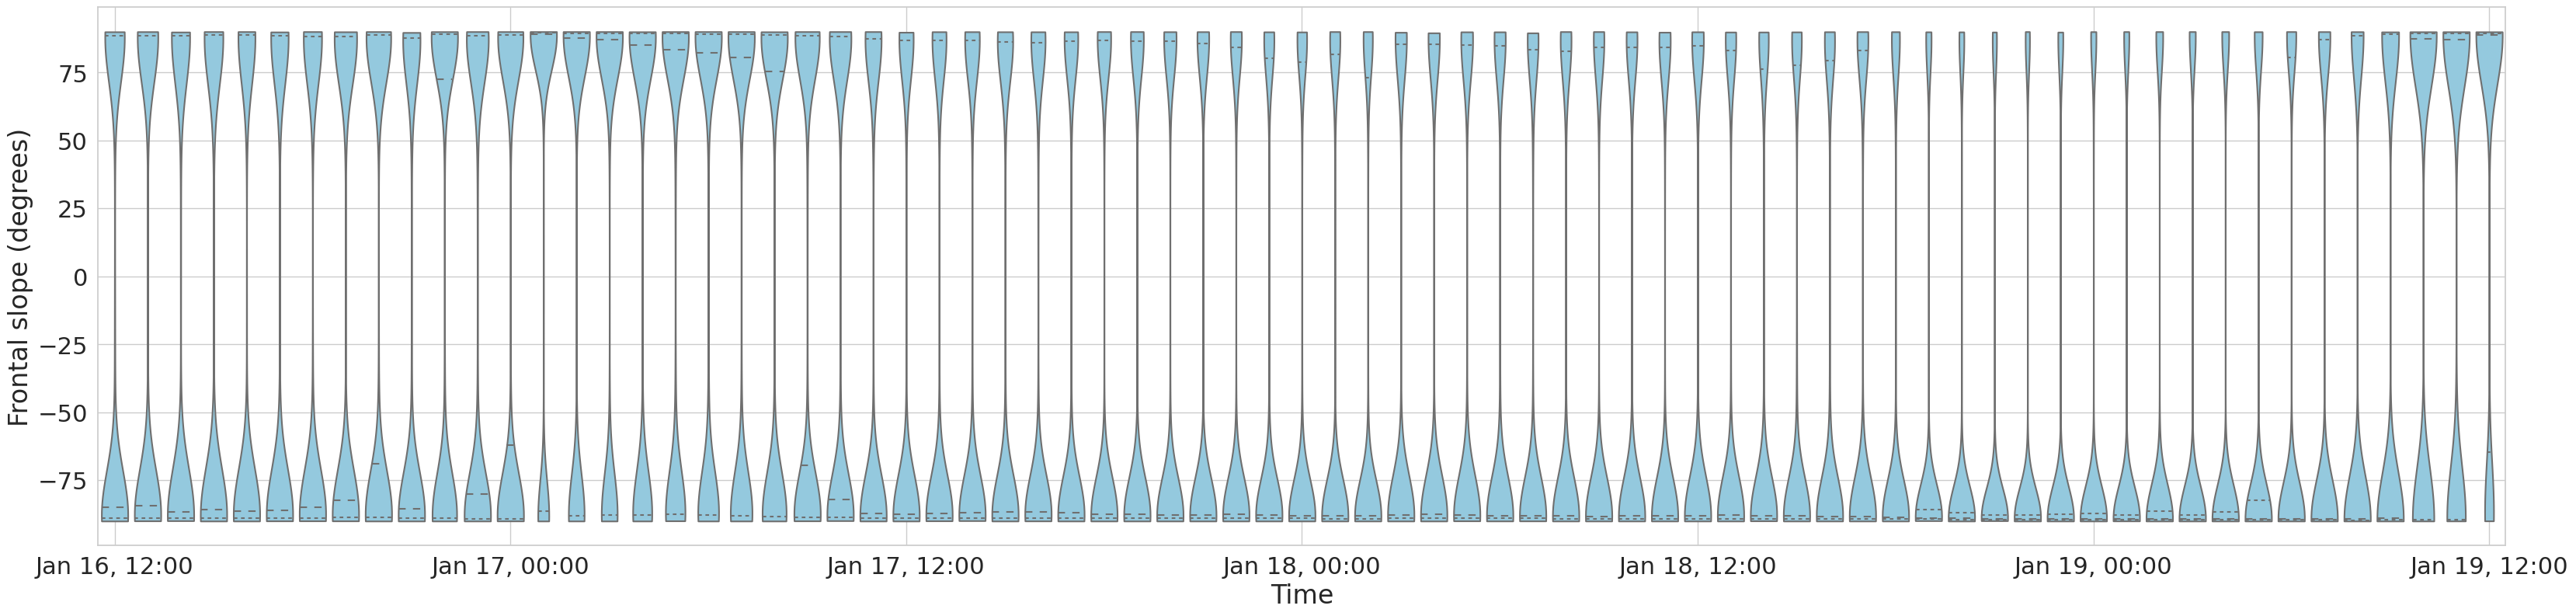

In [19]:
l_slope_ml = filter_parameter(dicts_ml_filtered, 'slope_stats')
plot_histogram_stats_development(l_slope_ml, 'Frontal slope (degrees)', date_list)     

In [20]:
def compute_time_dependend_emd(l_dicts_ml, l_dicts_selected_front, time_shift=1, variable='tfp_stats'):
    l_dicts_ml_ems = []
    for i in range(0, len(l_dicts_ml) - time_shift):
        l_dicts_ml_ts = [l_dicts_ml[i+time_shift][f] for f in range(0, len(l_dicts_ml[i+time_shift]))]
        l_emd = computed_emd(l_dicts_selected_front[i][variable], l_dicts_ml_ts, variable)
        for j in range(0, len(l_dicts_ml_ts)):
            l_dicts_ml_ts[j]['emd'] = l_emd[j]
        l_dicts_ml_ts = sorted(l_dicts_ml_ts, key=lambda d: d['emd'])
        l_dicts_ml_ems.append(l_dicts_ml_ts)
    return l_dicts_ml_ems
            

In [21]:
def plot_hist_emd_with_references(dist_ref, dist_aim, l_dists, l_labels, color_list=['lightskyblue'], scale='width', inner='quartile', cut=0, filename=''):
    sns.set(rc={'figure.figsize':((2+len(l_labels))*1.5,9)})
    sns.set(font_scale = 2)
    sns.set_style("whitegrid")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, len(l_labels)]})
    l_ref_dist = [dist_ref, dist_aim]

    sns.violinplot(ax=ax1, data=l_ref_dist, palette=['steelblue', 'lightskyblue'], scale=scale, inner=inner, cut=cut, saturation=1)
    ax1.set(ylabel="TFP")
    ax1.set(xticklabels=["Reference", "Aim"])
    ax1.xaxis.grid(True) # Show the vertical gridlines
    
    
    sns.violinplot(ax=ax2, data=l_dists, palette=color_list, scale=scale, inner=inner, cut=cut, saturation=1)
    ax2.set(xticklabels=l_labels)
    ax2.set(yticklabels='')
    ax2.set(xlabel="EMD")
    ax2.xaxis.grid(True) # Show the vertical gridlines
    
    # set y limit: 
    (bot1, top1) = ax1.get_ylim()
    (bot2, top2) = ax2.get_ylim()
    bot = min([bot1, bot2])
    top = max([top1, top2])
    
    # set ylimit 
    ax1.set_ylim((bot, top))
    ax2.set_ylim((bot, top))
    
    plt.subplots_adjust(wspace=0.03, hspace=0)
    plt.tight_layout()
    if filename != '':
        plt.savefig(filename)
    else: 
        plt.show()

In [22]:
def get_colors(n_colors, pos_match, std_color='lightcoral', match_color='lightskyblue'):
    l_colors = []
    for i in range(0, n_colors):
        if i == pos_match:
            l_colors.append(match_color)
        else:
            l_colors.append(std_color)
    return l_colors

time shift:  1
time 0
time shift:  3
time 0
time shift:  6
time 0
time shift:  12
time 0


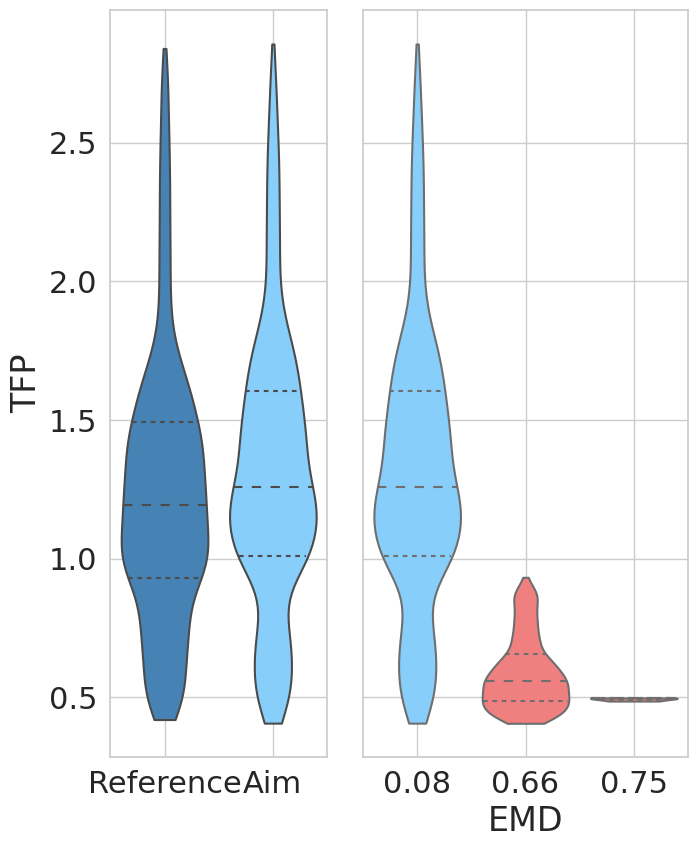

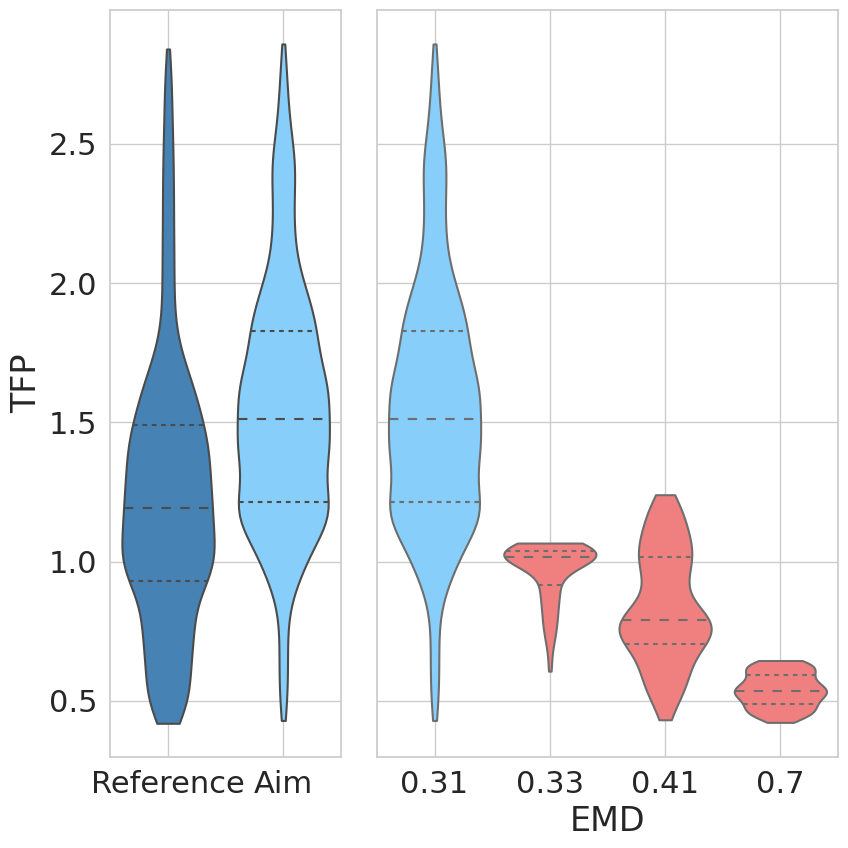

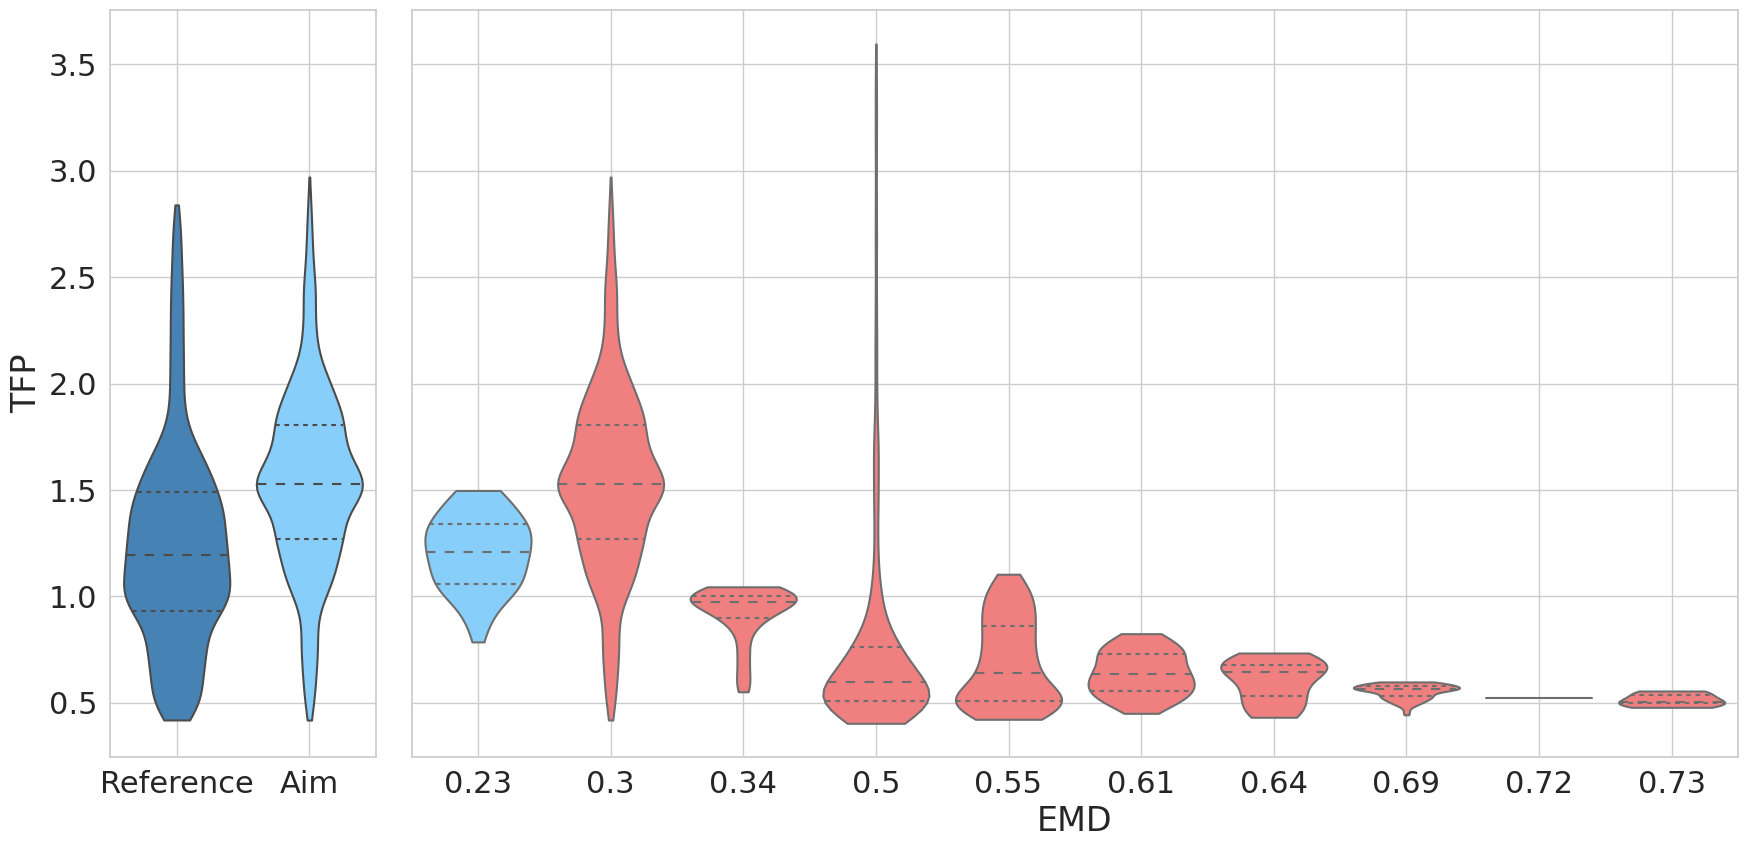

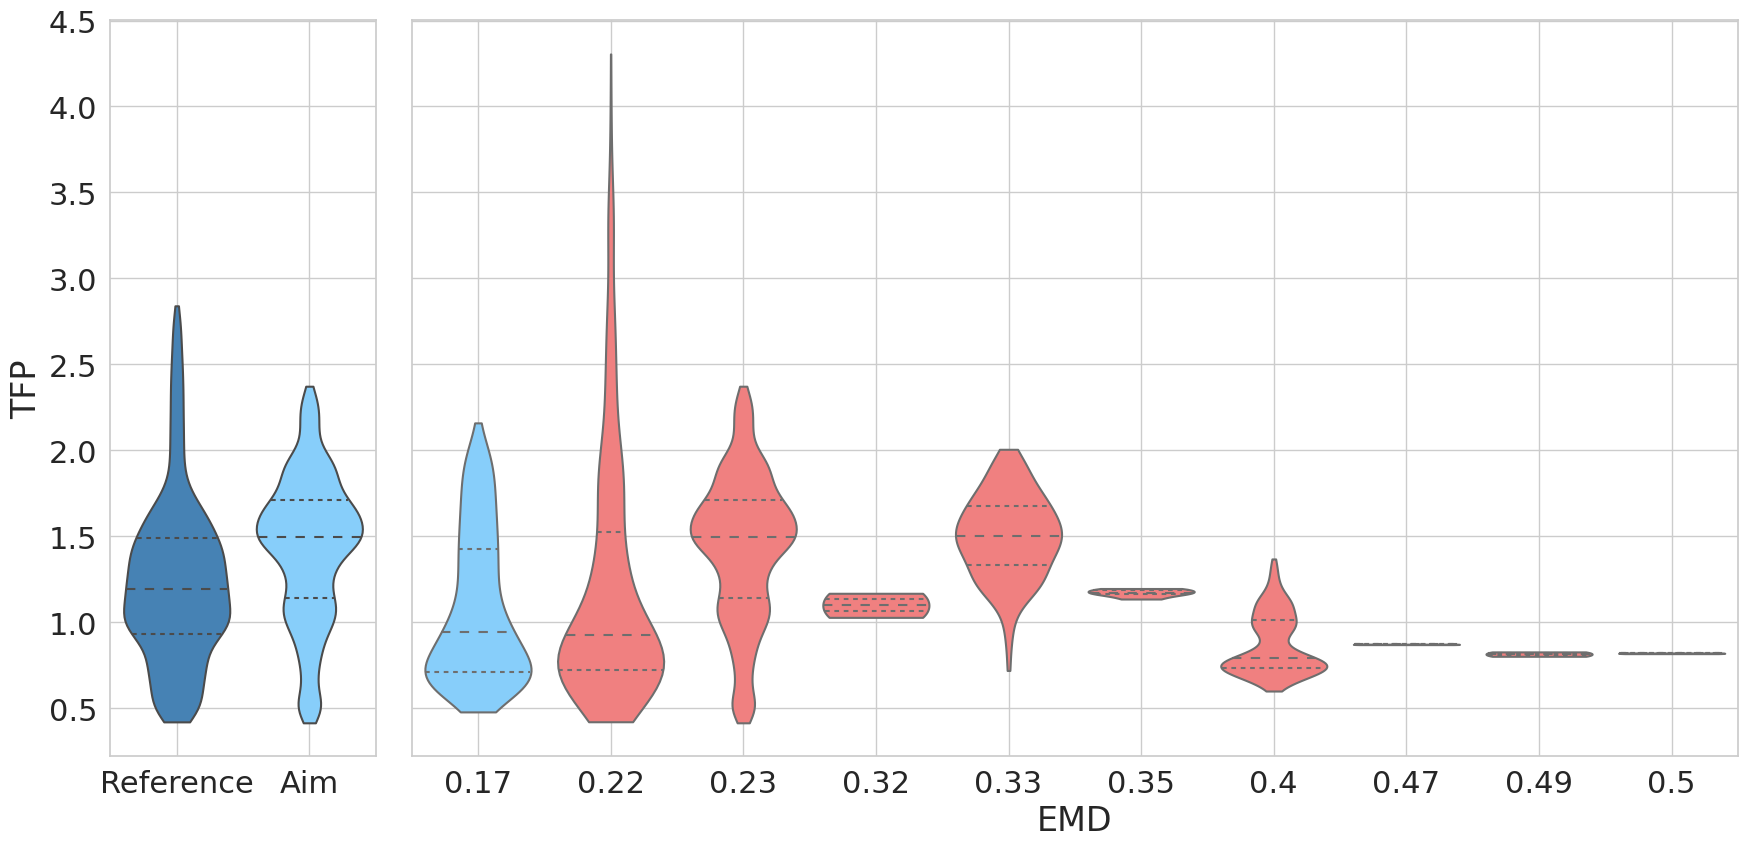

In [23]:
for time_shift in [1, 3, 6, 12]:
    for t in [0]: #, 24, 48]:
        l_fr_prob_emd = compute_time_dependend_emd(dicts_ml, dicts_ml_filtered, time_shift=time_shift)
        l_fr_prob_emd = filter_distance(l_fr_prob_emd[t], dicts_ml_filtered[t]['centroid_x'],
                                dicts_ml_filtered[t]['centroid_y'], time_shift*150+500)

        l_emd = [d['emd'] for d in l_fr_prob_emd]
        l_emd = [str(round(l, 2)) for l in l_emd]
        l_test_dist = [t['tfp_stats'] for t in l_fr_prob_emd]
        l_col = get_colors(10,0 )
        
        fig_name = 'tShift' + str(time_shift) + '_tStep' + str(t) + '.png'
        plot_hist_emd_with_references(dicts_ml_filtered[t]['tfp_stats'], dicts_ml_filtered[t + time_shift]['tfp_stats'], l_test_dist[:10], l_emd[:10], color_list=l_col, filename=fig_name)
        print('time shift: ', time_shift)
        print('time', t)

In [24]:
files_pl = [f for f in files if "pl-" in f]
tracks_pl = xr.open_dataset(base_path + "ECMWF_ens_pl.nc")
dicts_pl = open_pickle_dicts(files_pl, base_path, datacheck=True)
dicts_pl_filtered = filter_front_stats(tracks_pl, dicts_pl)

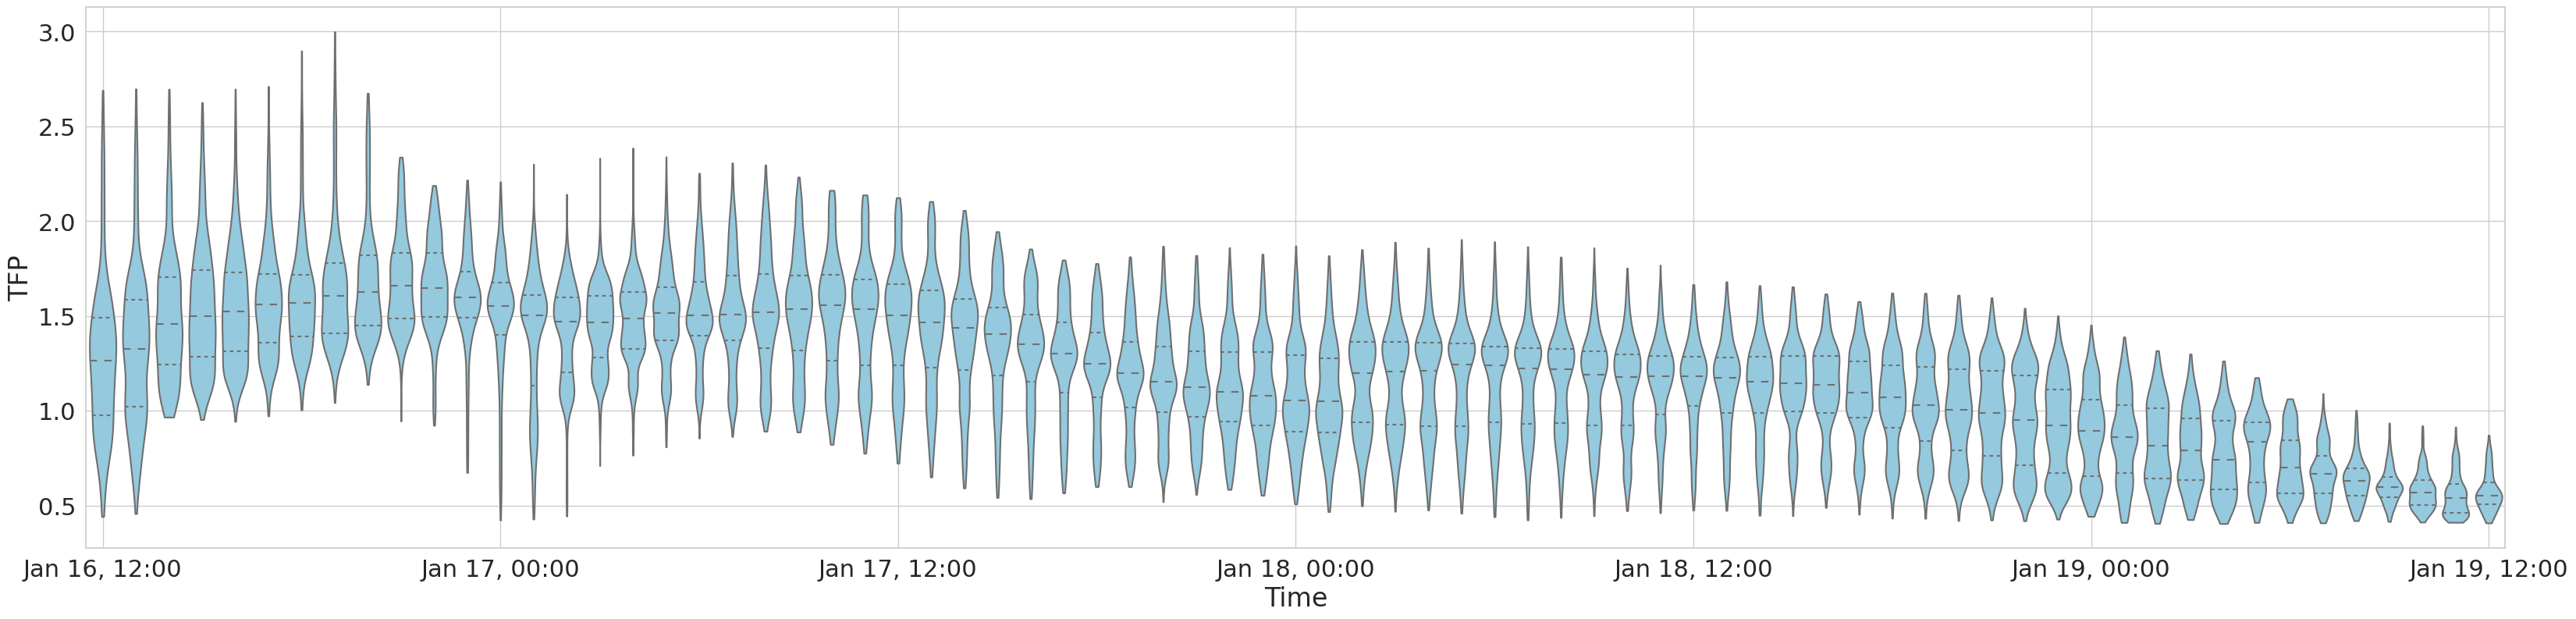

In [25]:
l_tfp_pl = filter_parameter(dicts_pl_filtered, 'tfp_stats')
plot_histogram_stats_development(l_tfp_pl, 'TFP', date_list)     

In [26]:
files_pl = [f for f in files if "pl-" in f]
tracks_pl = xr.open_dataset(base_path + "ECMWF_ens_pl.nc")
dicts_pl = open_pickle_dicts(files_pl, base_path)

dicts_pl_filtered = filter_front_stats(tracks_pl, dicts_pl)

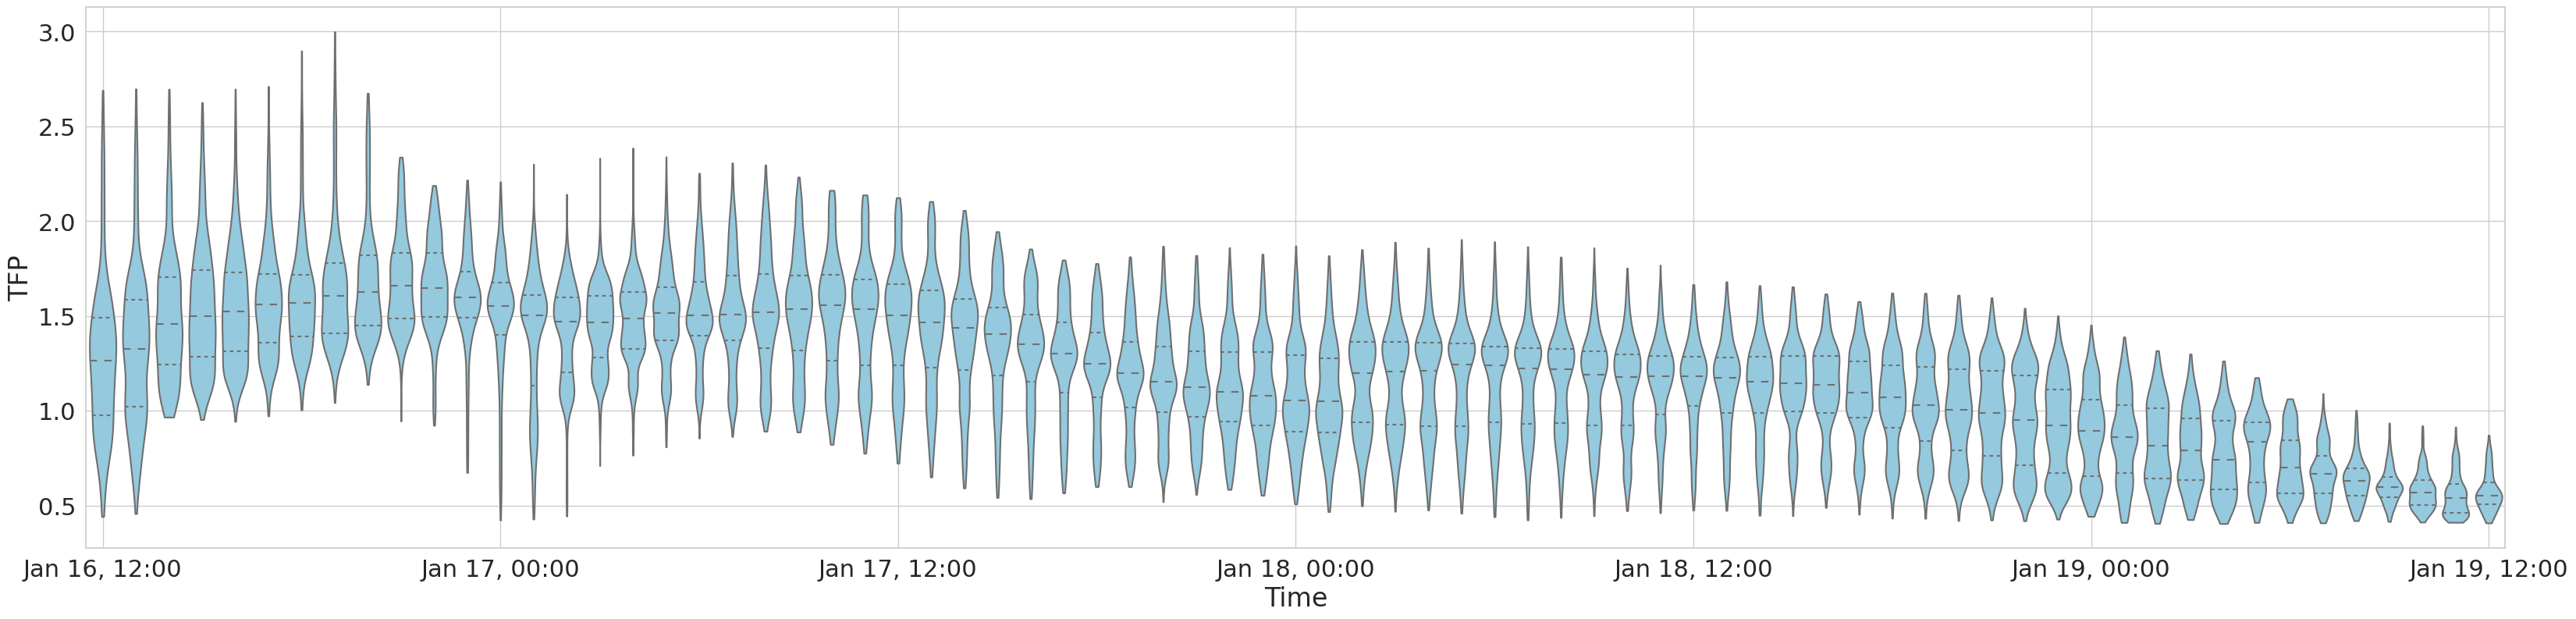

In [27]:
l_tfp_pl = filter_parameter(dicts_pl_filtered, 'tfp_stats')
plot_histogram_stats_development(l_tfp_pl, 'TFP', date_list)

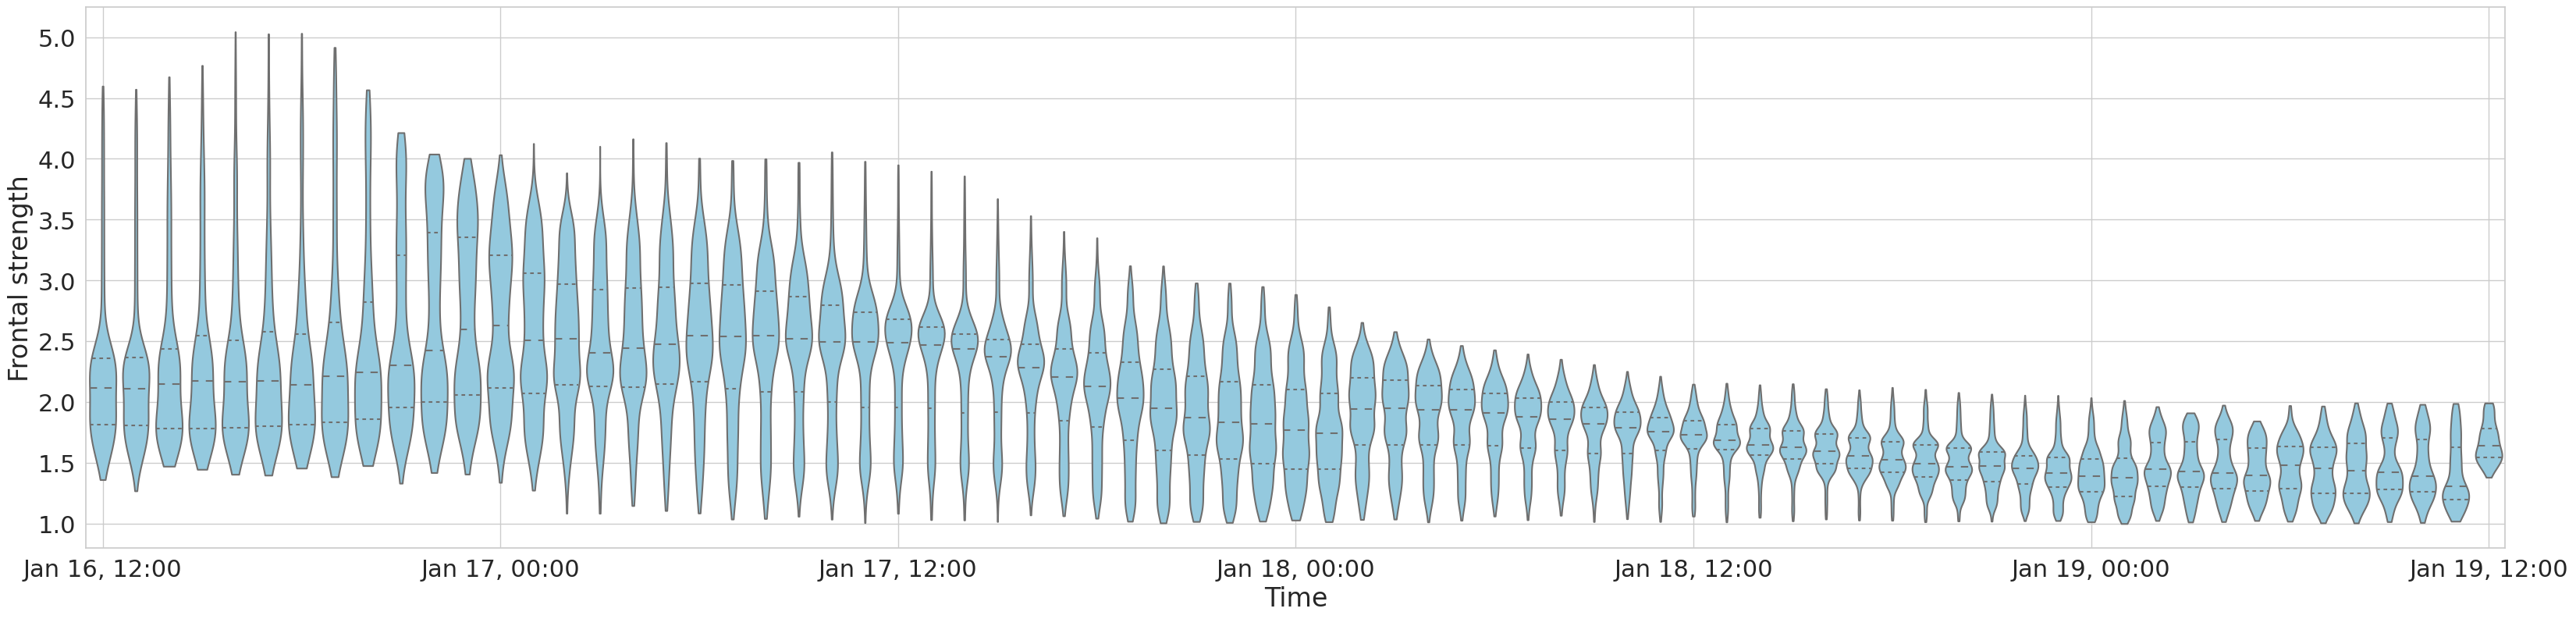

In [28]:
l_strength_pl = filter_parameter(dicts_pl_filtered, 'strength_stats')
plot_histogram_stats_development(l_strength_pl, 'Frontal strength', date_list)

In [29]:
from scipy.stats import wasserstein_distance
w_fs = [wasserstein_distance(l_strength_ml[i], l_strength_ml[i+1] ) for i in range(0, len(l_strength_ml)-1)]
w_tfp = [wasserstein_distance(l_tfp_ml[i], l_tfp_ml[i+1] ) for i in range(0, len(l_tfp_ml)-1)]

In [30]:
def filter_front_stats_ts0(tracks, d_stats):
    d_filtered_front_stats = []
    i = 0
    for l_ts in d_stats:
        centroid_x = tracks.isel(trajectory=i)['centroid_x'].values[0]
        centroid_y = tracks.isel(trajectory=i)['centroid_y'].values[0]
        for d_fr in l_ts:
            if (abs(d_fr['centroid_x'] - centroid_x) < 0.001) & (abs(d_fr['centroid_y'] - centroid_y) < 0.001): 
                d_filtered_front_stats.append(d_fr)
        i += 1
    return d_filtered_front_stats

In [31]:
base_path = "exampleData/friederike/tracking_ts0/"
files = os.listdir(base_path)

files_ts0 = [f for f in files if "pl-" in f]
tracks_ts0 = xr.open_dataset(base_path + "ECMWF_ens_pl.nc")
tracks_ts0 = tracks_ts0.isel(time=0)
dicts_ts0 = open_pickle_dicts(files_ts0, base_path)

dicts_ts0_filtered = filter_front_stats_ts0(tracks_ts0, dicts_ts0)

In [32]:
l_tfp_ts0 = filter_parameter(dicts_ts0_filtered, 'tfp_stats')
label_emd = []
for e in l_tfp_ts0:
    label_emd.append(round(wasserstein_distance(l_tfp_ts0[0], e), 2))
label_emd[0] = "Ref"

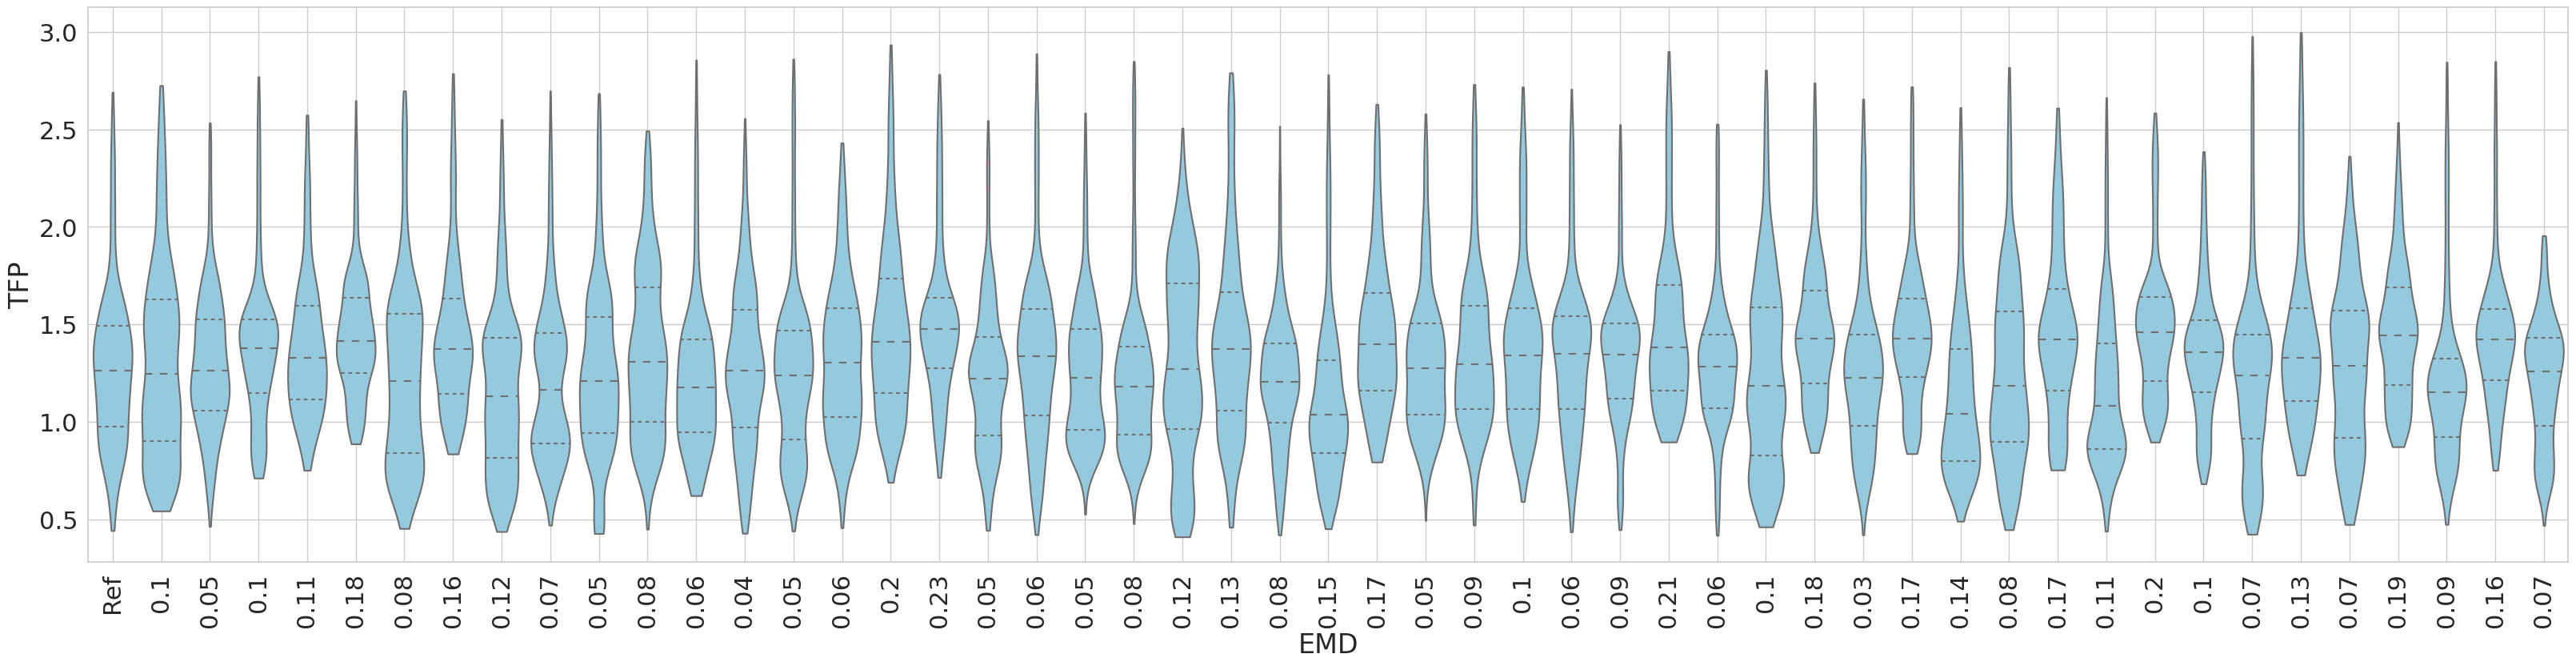

In [33]:
plot_histogram_stats_development(l_tfp_ts0, 'TFP', label_emd, x_label='EMD', label_intervall=1, scale="width", rotation=90)